In [1]:
from tensorflow.keras.layers import (Conv2D, UpSampling2D, Conv2DTranspose, concatenate, MaxPooling2D, 
                                     Activation, Dropout, Cropping2D, Flatten, Dense, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

Using TensorFlow backend.


In [2]:
IMG_HEIGHT = 300
IMG_WIDTH = 300
TRAIN_IMAGE_PATH = "jpeg/train/"
TEST_IMAGE_PATH = "jpeg/test/"
BATCH_SIZE = 8
AUTO = tf.data.experimental.AUTOTUNE
REG = 0.0005
EPOCHS=40
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.binary_crossentropy,
]

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df["image_name"] = train_df["image_name"].apply(lambda x: TRAIN_IMAGE_PATH + x + ".jpg")
test_df["image_name"] = test_df["image_name"].apply(lambda x: TEST_IMAGE_PATH + x + ".jpg")

In [5]:
train_df_target_1 = train_df[train_df["target"] == 1]
train_df_target_0 = train_df[train_df["target"] == 0]

In [6]:
del train_df

In [7]:
random_target_0 = np.random.randint(low=1, high=train_df_target_0.shape[0], 
                                    size=2 * train_df_target_1.shape[0])

In [8]:
train_df_d = pd.concat([train_df_target_0.iloc[random_target_0], train_df_target_1])

In [9]:
def decode_image(filename, label=None, image_size=(IMG_WIDTH, IMG_HEIGHT)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.cast(image, tf.float32)/255.0
    image = tf.image.resize(image, size=image_size)
    
    if label is None:
        return image
    else:
        return image, label
    
def data_augment(image, label=None):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.adjust_brightness(image, 0.2)
    image = tf.image.rot90(image)
    image = tf.image.central_crop(image, central_fraction=0.3)
    if label is None:
        return image
    else:
        return image, label

In [10]:
# lb = LabelEncoder()
# image_names = train_df["image_name"].values
# train_df["image_name"] = lb.fit_transform(train_df["image_name"].values)
# train_df["target"] = train_df["target"].astype("int")
# train_df.head()
# map_name_no = dict(zip(train_df["image_name"], image_names))
# y_train = train_df["target"]
# x_train = train_df[["image_name"]]


# over = SMOTE(random_state=45, sampling_strategy=0.1)
# under = RandomUnderSampler(sampling_strategy=0.5)
# steps = [('o', over), ('u', under)]
# ppl = Pipeline(steps=steps)
# x_train, y_train = ppl.fit_resample(x_train, y_train)

In [11]:
x_train = train_df_d[["image_name"]]
y_train = train_df_d["target"].astype(np.float32).values
x_train.reset_index(drop=True, inplace=True)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=45)
# x_train["image_name"] = x_train["image_name"].apply(lambda x: map_name_no[x])
# x_val["image_name"] = x_val["image_name"].apply(lambda x: map_name_no[x])

In [13]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1401, 1), (351, 1), (1401,), (351,))

In [14]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)

In [15]:
class_weights

array([0.74600639, 1.51623377])

In [16]:
train_dataset = (tf.data.Dataset
                 .from_tensor_slices((x_train["image_name"].values, y_train))
                 .map(decode_image, num_parallel_calls=AUTO)
                 .repeat()
                 .shuffle(512)
                 .batch(BATCH_SIZE)
                 .prefetch(AUTO)
                )

In [17]:
val_dataset = (tf.data.Dataset
               .from_tensor_slices((x_val["image_name"].values, y_val))
               .map(decode_image, num_parallel_calls=AUTO)
               .repeat()
               .shuffle(512)
               .batch(BATCH_SIZE)
               .prefetch(AUTO))

In [18]:
test_dataset = (tf.data.Dataset.from_tensor_slices((test_df.image_name))
                .map(decode_image, num_parallel_calls=AUTO)
                .cache()
                .batch(BATCH_SIZE))

In [19]:
lr = ReduceLROnPlateau(
    monitor="val_loss",
    patience=5,
    min_lr=0.000001,
    factor=0.5,
    verbose=1
)

In [20]:
es = EarlyStopping(monitor="val_loss", patience=10)

In [21]:
model_chkpt = ModelCheckpoint(filepath="best_model.h5")

In [22]:

def get_crop_shape(target, refer):
        # width, the 3rd dimension
        print("target: {} {}, refer: {} {}".format(target, target.get_shape(), refer, refer.get_shape()))
        cw = (target.get_shape()[2] - refer.get_shape()[2])
        assert (cw >= 0)
        if cw % 2 != 0:
            cw1, cw2 = int(cw/2), int(cw/2) + 1
        else:
            cw1, cw2 = int(cw/2), int(cw/2)
        # height, the 2nd dimension
        ch = (target.get_shape()[1] - refer.get_shape()[1])
        assert (ch >= 0)
        if ch % 2 != 0:
            ch1, ch2 = int(ch/2), int(ch/2) + 1
        else:
            ch1, ch2 = int(ch/2), int(ch/2)

        return (ch1, ch2), (cw1, cw2)

In [23]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)

In [24]:
def model_unet(input_layer, expansion_filters=64, expansion_kernel=(3,3), expansion_pool_size=(2,2),
          contract_filters=64, contract_kernel=(3,3), contract_pool_size=(2,2)):
    
    #64
    lvl_1 = Conv2D(filters=expansion_filters, kernel_size=expansion_kernel, activation="relu", padding="same")(input_layer)
    lvl_1 = Conv2D(filters=expansion_filters, kernel_size=expansion_kernel, activation="relu", padding="same")(lvl_1)
    mp_lvl_1 = MaxPooling2D(expansion_pool_size)(lvl_1)
    mp_lvl_1 = Dropout(0.25)(mp_lvl_1)
    
    #128
    lvl_2 = Conv2D(filters=expansion_filters*2, kernel_size=expansion_kernel, activation="relu", padding="same")(mp_lvl_1)
    lvl_2 = Conv2D(filters=expansion_filters*2, kernel_size=expansion_kernel, activation="relu", padding="same")(lvl_2)
    mp_lvl_2 = MaxPooling2D(expansion_pool_size)(lvl_2)
    mp_lvl_2 = Dropout(0.25)(mp_lvl_2)
    
    #256
    lvl_3 = Conv2D(filters=expansion_filters*3, kernel_size=expansion_kernel, activation="relu", padding="same")(mp_lvl_2)
    lvl_3 = Conv2D(filters=expansion_filters*3, kernel_size=expansion_kernel, activation="relu", padding="same")(lvl_3)
    mp_lvl_3 = MaxPooling2D(expansion_pool_size)(lvl_3)
    mp_lvl_3 = Dropout(0.25)(mp_lvl_3)
    
    #512
    lvl_4 = Conv2D(filters=expansion_filters*4, kernel_size=expansion_kernel, activation="relu", padding="same")(mp_lvl_3)
    lvl_4 = Conv2D(filters=expansion_filters*4, kernel_size=expansion_kernel, activation="relu", padding="same")(lvl_4)
    mp_lvl_4 = MaxPooling2D(expansion_pool_size)(lvl_4)
    mp_lvl_4 = Dropout(0.25)(mp_lvl_4)
    
    #1024
    lvl_5 = Conv2D(filters=expansion_filters*5, kernel_size=expansion_kernel, activation="relu", padding="same")(mp_lvl_4)
    lvl_5 = Conv2D(filters=expansion_filters*5, kernel_size=expansion_kernel, activation="relu", padding="same")(lvl_5)
    
    #d_lvl_4 = Conv2DTranspose(filters=contract_filters*4, kernel_size=contract_kernel, activation="relu", padding="same")(lvl_5)
    d_lvl_4 = UpSampling2D(size=contract_pool_size, data_format="channels_last")(lvl_5)
    ch, cw = get_crop_shape(lvl_4, d_lvl_4)
    ccon_4 = Cropping2D(cropping=(ch, cw), data_format="channels_last")(lvl_4)
    ucon_4 = concatenate([d_lvl_4, ccon_4])
    ucon_4 = Dropout(0.25)(ucon_4)
    ucon_4 = Conv2D(filters=contract_filters*4, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_4)
    ucon_4 = Conv2D(filters=contract_filters*4, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_4)
    
    #d_lvl_3 = Conv2DTranspose(filters=contract_filters*3, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_4)
    d_lvl_3 = UpSampling2D(size=contract_pool_size, data_format="channels_last")(ucon_4)
    ch, cw = get_crop_shape(lvl_3, d_lvl_3)
    ccon_3 = Cropping2D(cropping=(ch, cw), data_format="channels_last")(lvl_3)
    ucon_3 = concatenate([d_lvl_3, ccon_3])
    ucon_3 = Dropout(0.25)(ucon_3)
    ucon_3 = Conv2D(filters=contract_filters*3, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_3)
    ucon_3 = Conv2D(filters=contract_filters*3, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_3)
    
    #d_lvl_2 = Conv2DTranspose(filters=contract_filters*2, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_3)
    d_lvl_2 = UpSampling2D(size=contract_pool_size, data_format="channels_last")(ucon_3)
    ch, cw = get_crop_shape(lvl_2, d_lvl_2)
    ccon_2 = Cropping2D(cropping=(ch, cw), data_format="channels_last")(lvl_2)
    ucon_2 = concatenate([d_lvl_2, ccon_2])
    ucon_2 = Dropout(0.25)(ucon_2)
    ucon_2 = Conv2D(filters=contract_filters*3, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_2)
    ucon_2 = Conv2D(filters=contract_filters*3, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_2)
    
    #d_lvl_1 = Conv2DTranspose(filters=contract_filters*1, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_2)
    d_lvl_1 = UpSampling2D(size=contract_pool_size, data_format="channels_last")(ucon_2)
    ch, cw = get_crop_shape(lvl_1, d_lvl_1)
    ccon_1 = Cropping2D(cropping=(ch, cw), data_format="channels_last")(lvl_1)
    ucon_1 = concatenate([d_lvl_1, ccon_1])
    ucon_1 = Dropout(0.25)(ucon_1)
    ucon_1 = Conv2D(filters=contract_filters*1, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_1)
    ucon_1 = Conv2D(filters=contract_filters*1, kernel_size=contract_kernel, activation="relu", padding="same")(ucon_1)
    
    output = Conv2D(filters=1, kernel_size=(1,1), activation="relu", padding="same")(ucon_1)
    
    flatten = Flatten()(output)
    dense4 = Dense(256, activation='relu')(flatten)
    bn4 = BatchNormalization()(dense4)
    dense3 = Dense(256, activation='relu')(bn4)
    bn3 = BatchNormalization()(dense3)
    dense2 = Dense(128, activation='relu')(bn3)
    bn2 = BatchNormalization()(dense2)
    dense1 = Dense(1, activation="sigmoid")(bn2)
    model = Model(inputs=input_layer, outputs=dense1)
    return model
    
    
     

input_layer = Input((IMG_HEIGHT, IMG_WIDTH, 3))
model = model_unet(input_layer, expansion_filters=16)
model.summary()

target: Tensor("conv2d_7/Identity:0", shape=(None, 37, 37, 64), dtype=float32) (None, 37, 37, 64), refer: Tensor("up_sampling2d/Identity:0", shape=(None, 36, 36, 80), dtype=float32) (None, 36, 36, 80)
target: Tensor("conv2d_5/Identity:0", shape=(None, 75, 75, 48), dtype=float32) (None, 75, 75, 48), refer: Tensor("up_sampling2d_1/Identity:0", shape=(None, 72, 72, 256), dtype=float32) (None, 72, 72, 256)
target: Tensor("conv2d_3/Identity:0", shape=(None, 150, 150, 32), dtype=float32) (None, 150, 150, 32), refer: Tensor("up_sampling2d_2/Identity:0", shape=(None, 144, 144, 192), dtype=float32) (None, 144, 144, 192)
target: Tensor("conv2d_1/Identity:0", shape=(None, 300, 300, 16), dtype=float32) (None, 300, 300, 16), refer: Tensor("up_sampling2d_3/Identity:0", shape=(None, 288, 288, 192), dtype=float32) (None, 288, 288, 192)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         P

In [25]:
model

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=dice_loss, metrics=METRICS)

In [27]:
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[lr, es, model_chkpt],
                        steps_per_epoch=x_train.shape[0]//BATCH_SIZE, validation_data=val_dataset,
                        validation_steps=x_val.shape[0]//BATCH_SIZE,
                        class_weight = class_weights)

Train for 175 steps, validate for 43 steps
Epoch 1/40
175/175 [==============================] - 192s 1s/step - loss: 0.2101 - tp: 260.0000 - fp: 344.0000 - tn: 599.0000 - fn: 197.0000 - accuracy: 0.6136 - precision: 0.4305 - recall: 0.5689 - auc: 0.6481 - binary_crossentropy: 1.4534 - val_loss: 0.2634 - val_tp: 103.0000 - val_fp: 104.0000 - val_tn: 114.0000 - val_fn: 23.0000 - val_accuracy: 0.6308 - val_precision: 0.4976 - val_recall: 0.8175 - val_auc: 0.7194 - val_binary_crossentropy: 0.6729
Epoch 2/40
175/175 [==============================] - 175s 1s/step - loss: 0.1727 - tp: 290.0000 - fp: 277.0000 - tn: 660.0000 - fn: 173.0000 - accuracy: 0.6786 - precision: 0.5115 - recall: 0.6263 - auc: 0.7097 - binary_crossentropy: 1.6554 - val_loss: 0.1975 - val_tp: 46.0000 - val_fp: 24.0000 - val_tn: 191.0000 - val_fn: 83.0000 - val_accuracy: 0.6890 - val_precision: 0.6571 - val_recall: 0.3566 - val_auc: 0.7487 - val_binary_crossentropy: 0.6203
Epoch 3/40
175/175 [===========================

175/175 [==============================] - 191s 1s/step - loss: 0.1279 - tp: 311.0000 - fp: 196.0000 - tn: 736.0000 - fn: 157.0000 - accuracy: 0.7479 - precision: 0.6134 - recall: 0.6645 - auc: 0.7877 - binary_crossentropy: 1.7562 - val_loss: 0.2354 - val_tp: 100.0000 - val_fp: 114.0000 - val_tn: 113.0000 - val_fn: 17.0000 - val_accuracy: 0.6192 - val_precision: 0.4673 - val_recall: 0.8547 - val_auc: 0.7883 - val_binary_crossentropy: 1.9926
Epoch 18/40
175/175 [==============================] - 195s 1s/step - loss: 0.1226 - tp: 313.0000 - fp: 190.0000 - tn: 755.0000 - fn: 142.0000 - accuracy: 0.7629 - precision: 0.6223 - recall: 0.6879 - auc: 0.7977 - binary_crossentropy: 1.6264 - val_loss: 0.3047 - val_tp: 120.0000 - val_fp: 221.0000 - val_tn: 0.0000e+00 - val_fn: 3.0000 - val_accuracy: 0.3488 - val_precision: 0.3519 - val_recall: 0.9756 - val_auc: 0.8286 - val_binary_crossentropy: 2.3656
Epoch 19/40
175/175 [==============================] - 198s 1s/step - loss: 0.1234 - tp: 311.0000

In [28]:
history

In [29]:
pred_unet = model.predict(test_dataset, verbose=1)

1373/1373 [==============================] - 855s 623ms/step


In [30]:
pred_unet

array([[0.05055937],
       [0.00483434],
       [0.00292812],
       ...,
       [0.00957957],
       [0.00368847],
       [0.6064426 ]], dtype=float32)

In [31]:
import matplotlib.pyplot as plt

In [32]:
loss_ = history.history["loss"]
val_loss_ = history.history["val_loss"]
epochs = [i for i in range(11)]

ValueError: x and y must have same first dimension, but have shapes (11,) and (29,)

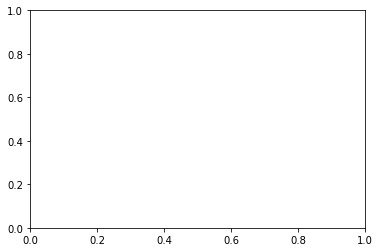

In [33]:
plt.plot(epochs, loss_, 'bo', label="Training loss")
plt.plot(epochs, val_loss_, 'b', label="validation loss")
plt.legend()

In [34]:
def model_vgg16():
    model_vgg16 = VGG16(weights="imagenet", include_top=False,
                        input_shape=(IMG_HEIGHT, IMG_WIDTH,3))
    for layer in model_vgg16.layers[:-5]:
        layer.trainable = False
    flat = Flatten()(model_vgg16.output)
    output = Dense(1, activation="sigmoid")(flat)
    model = Model(model_vgg16.input, outputs=output)
    model.summary()
    return model

In [35]:
model_vgg16_ = model_vgg16()
model_chkpt_vgg16 = ModelCheckpoint(filepath="best_vgg16.h5")
model_vgg16_.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-04), loss=dice_loss, metrics=[METRICS])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0   

In [36]:
history = model_vgg16_.fit(train_dataset, epochs=EPOCHS, callbacks=[lr,es, model_chkpt],
                           steps_per_epoch = x_train.shape[0]//BATCH_SIZE, 
                           validation_data=val_dataset,
                           validation_steps=x_val.shape[0]//BATCH_SIZE, class_weight = class_weights)

Train for 175 steps, validate for 43 steps
Epoch 1/40
175/175 [==============================] - 124s 707ms/step - loss: 0.1670 - tp: 2.0000 - fp: 4.0000 - tn: 934.0000 - fn: 460.0000 - accuracy: 0.6686 - precision: 0.3333 - recall: 0.0043 - auc: 0.4996 - binary_crossentropy: 11.2495 - val_loss: 0.1555 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 237.0000 - val_fn: 107.0000 - val_accuracy: 0.6890 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_crossentropy: 11.3679
Epoch 2/40
175/175 [==============================] - 119s 678ms/step - loss: 0.1721 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 918.0000 - fn: 482.0000 - accuracy: 0.6557 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5000 - binary_crossentropy: 12.5956 - val_loss: 0.1831 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 218.0000 - val_fn: 126.0000 - val_accuracy: 0.6337 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_binary_crossentropy: 13.6512
E

In [38]:
pred_vgg16 = model_vgg16_.predict(test_dataset, verbose=1)

1373/1373 [==============================] - 182s 133ms/step


In [39]:
sam = pd.read_csv("sample_submission.csv")

In [40]:
sam.head()


image_name  target
0  ISIC_0052060       0
1  ISIC_0052349       0
2  ISIC_0058510       0
3  ISIC_0073313       0
4  ISIC_0073502       0

In [41]:
sam["target"] = (pred_unet + pred_vgg16)/2.0

In [42]:
sam

image_name    target
0      ISIC_0052060  0.025280
1      ISIC_0052349  0.002417
2      ISIC_0058510  0.001464
3      ISIC_0073313  0.001107
4      ISIC_0073502  0.049588
...             ...       ...
10977  ISIC_9992485  0.002319
10978  ISIC_9996992  0.018377
10979  ISIC_9997917  0.004790
10980  ISIC_9998234  0.001844
10981  ISIC_9999302  0.303221

[10982 rows x 2 columns]

In [43]:
sam.to_csv("unet_vgg16_ensemble.csv", index=False)